### 🔧 环境配置和检查

#### 概述

本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：

- 使用统一的conda环境：激活统一的学习环境
- 通过国内镜像源快速安装依赖：配置pip使用清华镜像源
- 加速模型下载：设置HuggingFace镜像代理
- 检查系统配置：检查硬件和软件配置

#### 配置

- **所需环境及其依赖已经部署好**
- 在`Notebook`右上角选择`jupyter内核`为`python(flyai_agent_in_action)`，即可执行下方代码

In [ ]:
%%script bash

# 1. 激活 conda 环境 (仅对当前单元格有效)
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action

echo "========================================="
echo "== Conda 环境检查报告 (仅针对当前 Bash 子进程) =="
echo "========================================="

# 2. 检查当前激活的环境
CURRENT_ENV_NAME=$(basename $CONDA_PREFIX)

if [ "$CURRENT_ENV_NAME" = "flyai_agent_in_action" ]; then
    echo "✅ 当前单元格已成功激活到 flyai_agent_in_action 环境。"
    echo "✅ 正在使用的环境路径: $CONDA_PREFIX"
    echo ""
    echo "💡 提示: 后续的 Python 单元格将使用 Notebook 当前选择的 Jupyter 内核。"
    echo "   如果需要后续单元格也使用此环境，请执行以下操作:"
    echo "   1. 检查 Notebook 右上角是否已选择 'python(flyai_agent_in_action)'。"
else
    echo "❌ 激活失败或环境名称不匹配。当前环境: $CURRENT_ENV_NAME"
    echo ""
    echo "⚠️ 严重提示: 建议将 Notebook 的 Jupyter **内核 (Kernel)** 切换为 'python(flyai_agent_in_action)'。"
    echo "   (通常位于 Notebook 右上角或 '内核' 菜单中)"
    echo ""
    echo "📚 备用方法 (不推荐): 如果无法切换内核，则必须在**每个**代码单元格的头部重复以下命令:"
    echo ""
    echo "%%script bash"
    echo "# 必须在每个单元格都执行"
    echo "eval \"\$(conda shell.bash hook)\""
    echo "conda activate flyai_agent_in_action"
fi

echo "=========================================" 

In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-4/parallelization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 并行节点执行（Parallel node execution）

## 回顾（Review）

在第 3 章中，我们深入讲解了“人机协作（human-in-the-loop）”，展示了 3 个常见场景：

(1) `审批（Approval）`：暂停代理执行，向用户展示当前状态，请用户确认/放行某个动作。

(2) `调试（Debugging）`：回溯图（rewind the graph），以复现或规避问题。

(3) `编辑（Editing）`：直接修改状态。

## 目标（Goals）

本章在第 3 章的人机协作基础上，结合第 2 章的“记忆（memory）”概念，进一步推进。

我们将进入“多智能体（multi-agent）”工作流，并最终构建一个把本课程各模块串联起来的多智能体研究助理。

为此，我们先介绍一些与 LangGraph 可控性相关的主题。

本章从[并行化（parallelization）](https://langchain-ai.github.io/langgraph/how-tos/branching/#how-to-create-branches-for-parallel-node-execution)开始。

## 扇出与扇入（Fan out and fan in）

我们先构建一个简单的线性图，在每一步都覆盖（overwrite）状态。

In [1]:
%%capture --no-stderr
# %pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk
%pip install --quiet langgraph==0.6.7 langchain_openai==0.3.32  langgraph_sdk==0.2.6 langchain_community==0.3.29 tavily-python==0.7.12 wikipedia==1.4.0

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置 OpenAI API 密钥
# 这是使用 OpenAI 模型所必需的
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


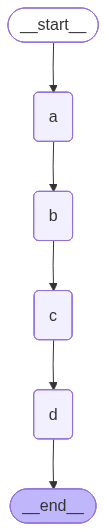

In [5]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

# 定义状态的类型
class State(TypedDict):
    # 'state' 键将存储字符串列表，使用 operator.add 作为归约器（reducer）
    # operator.add 对于列表来说是拼接操作，使得更新是追加而不是覆盖
    state: str

# 定义一个节点类，用于向状态中添加一个秘密值
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        # 初始化节点时存储秘密值
        self._value = node_secret

    # 这个方法将在节点执行时被调用
    def __call__(self, state: State) -> Any:
        # 打印当前状态和要添加的值
        print(f"Adding {self._value} to {state['state']}")
        # 返回一个字典，更新状态中的 'state' 键
        return {"state": [self._value]}

# 构建一个状态图
builder = StateGraph(State)

# 添加节点到图中，每个节点都使用 ReturnNodeValue 类并传入一个秘密值
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# 定义图的流程（边）
# 从开始节点 START 到节点 "a"
builder.add_edge(START, "a")
# 从节点 "a" 到节点 "b"
builder.add_edge("a", "b")
# 从节点 "b" 到节点 "c"
builder.add_edge("b", "c")
# 从节点 "c" 到节点 "d"
builder.add_edge("c", "d")
# 从节点 "d" 到结束节点 END
builder.add_edge("d", END)

# 编译图，使其可执行
graph = builder.compile()

# 绘制图的 Mermaid 图并显示
display(Image(graph.get_graph().draw_mermaid_png()))

如预期所示，我们在每一步都“覆盖（overwrite）”了 `state`。

对初学者提示：如果希望“追加（append）”而不是覆盖，需要为该状态键配置一个“归约器（Reducer）”来合并同一步里来自多个节点的更新，见下文示例。

In [6]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

现在，我们让 `b` 和 `c` 并行运行，随后再运行 `d`。

做法：从 `a` 同时“扇出（fan-out）”到 `b` 与 `c`，再“扇入（fan-in）”到 `d`。

注意：状态更新会在每个步骤（step）结束时统一应用。

下面运行看看。

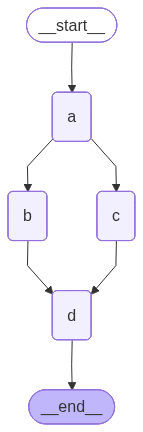

In [7]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

**这里会报错**！

原因：在同一个步骤里，`b` 和 `c` 同时向同一个状态键/通道（`state`）写入数据。默认规则是“每个步骤每个键只能接收一个值”。

解决思路：为该键配置支持多值合并的“归约器（Reducer）”（下文使用 `operator.add` 作为示例）。

In [8]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


在使用扇出时，如果同一步里会向同一个状态键/通道写入多个值，就必须为该键配置“归约器（Reducer）”。

在第 2 章我们提过，`operator.add` 是 Python 内置模块 operator 中的函数。

当 `operator.add` 应用于列表时，它表示“列表拼接”（list concatenation），可把多个更新合并为一个列表。

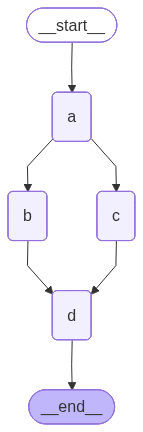

In [9]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

现在可以看到：并行的 `b` 与 `c` 对 `state` 的更新被“追加（append）”到列表中，而不是互相覆盖。

## 等待并行分支全部完成（Waiting for nodes to finish）

考虑一个情形：某条并行路径比另一条路径多一步（更长）。

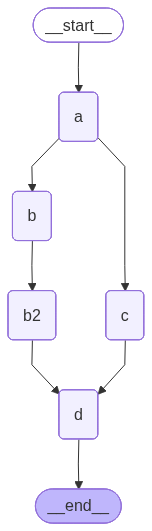

In [10]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

在这个例子里，`b`、`b2` 与 `c` 同属于同一个步骤（step）。

因此，图会等待它们全部执行完毕，才会推进到下一步 `d`。

In [11]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## 控制同一步内的更新顺序（Setting the order of state updates）

注意：在同一个步骤内，更新的“应用次序”并非由我们显式控制。

更准确地说，LangGraph 会基于图的拓扑关系给出一个确定性的次序，但这个次序**不受我们直接控制**。

上面输出中可以看到：`c` 的更新先于 `b2` 生效。

如果需要稳定的顺序，我们可以自定义一个“归约器（Reducer）”，例如对合并后的列表进行排序。

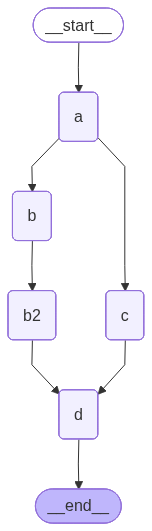

In [12]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]

    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

现在，归约器会对合并后的 `state` 值进行排序！

上述 `sorting_reducer` 是“全局排序”的示例。你也可以采用更工程化的方式：

1. 在并行步骤中，先把各分支输出写入到状态里的一个临时字段；
2. 在并行步骤之后，增加一个“汇聚（sink）”节点，统一读取临时字段并按需要的规则组合与排序；
3. 合并完成后，清理临时字段，保证状态整洁。

更多细节参见文档：[稳定排序（stable sorting）](https://langchain-ai.github.io/langgraph/how-tos/branching/#stable-sorting)。


## 结合大模型（LLM）

我们来做一个更贴近实战的示例：

目标：从两个外部来源（Wikipedia 与 Web 搜索）收集上下文，再让 LLM 基于这些上下文来回答问题。

In [15]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [16]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

你可以尝试不同的 Web 搜索工具。[Tavily](https://app.tavily.com/home) 是一个不错的选择。使用前请确保已设置环境变量 `TAVILY_API_KEY`。

In [17]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


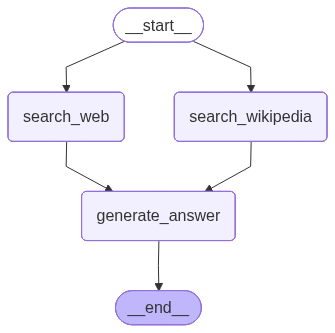

In [28]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

# 定义一个节点函数，用于从 Web 搜索中检索文档
def search_web(state):

    """ Retrieve docs from web search """

    # 初始化 Tavily 搜索工具，最多返回 3 个结果
    tavily_search = TavilySearchResults(max_results=3)
    # 使用状态中的问题进行搜索
    search_docs = tavily_search.invoke(state['question'])

     # 格式化搜索结果，将每个文档的内容和链接包装在 <Document> 标签中
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    print("Formatted Web Docs:")
    print(formatted_search_docs)

    # 返回一个字典，将格式化后的文档列表作为 'context' 键的值
    return {"context": [formatted_search_docs]}

# 定义一个节点函数，用于从 Wikipedia 检索文档
def search_wikipedia(state):

    """ Retrieve docs from wikipedia """

    # 初始化 Wikipedia 加载器，最多加载 2 个文档
    search_docs = WikipediaLoader(query=state['question'],
                                  load_max_docs=2).load()

     # 格式化搜索结果，将每个文档的内容、来源和页码包装在 <Document> 标签中
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    print("Formatted Wikipedia Docs:")
    print(formatted_search_docs)

    # 返回一个字典，将格式化后的文档列表作为 'context' 键的值
    return {"context": [formatted_search_docs]}

# 定义一个节点函数，用于根据上下文生成答案
def generate_answer(state):

    """ Node to answer a question """

    # 从状态中获取上下文和问题
    context = state["context"]
    question = state["question"]

    # 定义用于生成答案的模板
    # answer_template = """Answer the question {question} using this context: {context}"""
    answer_template = """使用此上下文:{context} 回答问题 {question} """
    # 使用问题和上下文格式化指令
    answer_instructions = answer_template.format(question=question,
                                                       context=context)

    # 调用 LLM 模型生成答案，输入包括系统消息和人类消息
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])

    # 返回一个字典，将生成的答案作为 'answer' 键的值
    return {"answer": answer}

# 初始化状态图，状态类型为 State
builder = StateGraph(State)

# 添加节点到图中，每个节点对应一个上面定义的函数
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# 定义图的流程（边）
# 从开始节点 START 同时连接到 "search_wikipedia" 和 "search_web"，实现并行执行
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
# 从 "search_wikipedia" 连接到 "generate_answer"
builder.add_edge("search_wikipedia", "generate_answer")
# 从 "search_web" 连接到 "generate_answer"
builder.add_edge("search_web", "generate_answer")
# 从 "generate_answer" 连接到结束节点 END
builder.add_edge("generate_answer", END)
# 编译图，使其可执行
graph = builder.compile()

# 绘制图的 Mermaid 图并显示
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
result = graph.invoke({"question": "Nvidia 2025年第二季度财报表现如何？"})
result['answer'].content

Formatted Wikipedia Docs:

Formatted Web Docs:
<Document href="https://nvidianews.nvidia.com/news/nvidia-announces-financial-results-for-second-quarter-fiscal-2026">
NVIDIA (NASDAQ: NVDA) today reported revenue for the second quarter ended July 27, 2025, of $46.7 billion, up 6% from the previous quarter and up 56% from a year ago. NVIDIA’s Blackwell Data Center revenue grew 17% sequentially.

There were no H20 sales to China-based customers in the second quarter.NVIDIA benefited from a $180 million release of previously reserved H20 inventory, from approximately $650 million in unrestricted H20 sales to a customer outside of China. [...] During the first half of fiscal 2026, NVIDIA returned $24.3 billion to shareholders in the form of shares repurchased and cash dividends. As of the end of the second quarter, the company had $14.7 billion remaining under its share repurchase authorization. On August 26, 2025, the Board of Directors approved an additional $60.0 billion to the Company’s 

"Nvidia's financial performance for the second quarter of 2025 was strong. The company reported revenue of $46.7 billion, which was up 6% from the previous quarter and up 56% from a year ago. The Blackwell Data Center revenue grew 17% sequentially. Nvidia's data center revenue was $41.1 billion, up 5% from the previous quarter and up 56% from a year ago. The company achieved a gross margin of 72.4%, exceeding market expectations of 71.9%. Despite the impact of the H20 chip ban, which led to a significant inventory write-down, Nvidia's revenue growth was driven by its data center and gaming businesses. The company also returned $24.3 billion to shareholders through share repurchases and cash dividends during the first half of fiscal 2026."

## 结合 LangGraph API 使用

**⚠️ 说明**

自视频录制后，Studio 已更新为可在本地运行并通过浏览器访问。推荐使用本地方式（而不是视频中展示的桌面应用）。

- 本地开发服务器文档：[链接](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)
- 如何启动本地 Studio：[链接](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)

在本模块的 `/studio` 目录下，执行：

```
langgraph dev
```

启动后你将看到类似输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

在浏览器打开 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

In [ ]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [ ]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [ ]:
thread = await client.threads.create()
input_question = {"question": "How were Nvidia Q2 2024 earnings?"}
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="parallelization",
                                      input=input_question,
                                      stream_mode="values"):
    # Check if answer has been added to state
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])

Nvidia's Q2 2024 earnings were strong, showcasing record revenue and a robust performance in its data center division. The company reported revenue of $30.0 billion, which was up 15% from the previous quarter and up 122% from a year ago. GAAP earnings per diluted share were $0.67, up 12% from the previous quarter and up 168% from a year ago. Non-GAAP earnings per diluted share were $0.68, up 11% from the previous quarter and up 152% from a year ago. However, the gross margin saw a decline from 78% in Q1 to 75% in Q2, which could indicate higher production costs or more aggressive pricing strategies. Despite this, Nvidia remains a dominant force in the AI chip sector.
